## Empirical Analysis of Similarity Sensitivity in Image Embedding Neighborhoods

Several studies suggest that Approximate Nearest Neighbor (ANN) algorithms substantially reduce the computational expense of a similarity search while maintaining high precision. However, few publications work to directly examime how similarity structure deforms under approzimation as neighborhood size varies. This notebooks conducts an emprical analysis of similarity sensitivity in image embeddings by comparing linear (exact) and approximate nearest neighbor (ANN) searches for varying k-values. 

## Step 1: Project Dependencies
Load all required libraries and verify the computational environment.

### (Optional) Install Dependencies
If the environment has not been initialiaze, install all required packages:

```bash
pip install -r requirements.txt

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
import faiss
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import models
import os 
import json

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("PyTorch version:", torch.__version__)
print("FAISS version:", faiss.__version__)
print("Using device:", device)

PyTorch version: 2.9.1
FAISS version: 1.12.0
Using device: cpu


## Step 2: Experiment Configuration
Define the dataset path, preprocessing pipeline, and hyperparameters used throughout the experiment.

In [ ]:
# Path to STL-10 image dataset
DATA_PATH = "./data/stl10-data"

EMB_FILE = "./data/embeddings_resnet50_stl10.npy"
EMB_CHUNK_DIR = "./data/emb_chunks"


# Batch size for embedding extraction
BATCH_SIZE = 32

# k-values to sweep for neighborhood analysis
K_VALUES = [5, 10, 20, 50, 100, 200, 500]

# Distance metric: "cosine" or "euclidean"
METRIC = "cosine"  


# HNSW parameters
M = 32           # graph connectivity (higher = more accurate, slower)
EF_CONSTRUCTION = 200
EF_SEARCH = 50   # controls ANN accuracy during search


# Preprocessing pipeline: Transforms/Normalizes images according 
# to the mean and standard deviation of ImageNet.
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Verify configurations are correct
print("Config loaded:")
print(" - Dataset path:", DATA_PATH)
print(" - Batch size:", BATCH_SIZE)
print(" - k sweep:", K_VALUES)
print(" - Metric:", METRIC)


Config loaded:
 - Dataset path: ./data/stl10-data
 - Batch size: 32
 - k sweep: [5, 10, 20, 50, 100, 200, 500]
 - Metric: cosine


## Step 3: Load Dataset
Load the STL-10 dataset and verify its size, structure, and sample images.

Dataset loaded:
 - Number of samples: 100000
 - Image size: torch.Size([3, 224, 224])


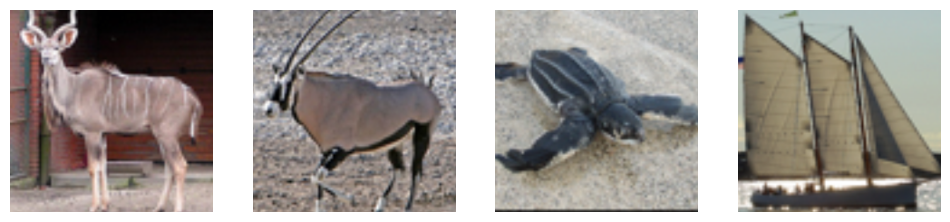

In [3]:
# Add note about dataset here 
dataset = STL10(
    root=DATA_PATH,
    split="unlabeled",  # 100k natural images
    download=True,
    transform=transform
)

# Verify dataset size and dimensions.
print("Dataset loaded:")
print(" - Number of samples:", len(dataset))
print(" - Image size:", dataset[0][0].shape)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# (Optional) Preview Samples
def show_samples(dataset, num=4):
    fig, axes = plt.subplots(1, num, figsize=(12, 3))
    for i in range(num):
        img, _ = dataset[i]
        disp = img.permute(1, 2, 0).numpy()
        disp = disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        disp = np.clip(disp, 0, 1)
        axes[i].imshow(disp)
        axes[i].axis("off")
    plt.show()

show_samples(dataset)

## Step 4: Load Pre-trained ResNet-50 Model
Load an ImageNet-trained ResNet-50 and expose its penultimate layer for embedding extraction.

In [4]:
# Load pretrained ResNet-50 (ImageNet-trained weights)
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Remove the final classification layer to expose penultimate embeddings
embedding_model = torch.nn.Sequential(*list(resnet.children())[:-1])
embedding_model.to(device)
embedding_model.eval()

# Embedding extraction function
def extract_embeddings(batch):
    with torch.no_grad():
        feats = embedding_model(batch.to(device))
        # Output shape: (batch_size, 2048, 1, 1) → squeeze to (batch_size, 2048)
        feats = feats.squeeze(-1).squeeze(-1)
    return feats.cpu().numpy().astype("float32")

print("Embedding dimension:", 2048)

Embedding dimension: 2048


## Step 5: Generate Image Embeddings
Extract 2048-dimensional ResNet-50 embeddings for all images, saving batch-level chunks to disk and automatically skipping extraction on future runs if a complete embedding file already exists.

In [ ]:
# -------------------------------------------------------
# 1. If the final embedding file exists, load & skip work
# -------------------------------------------------------
if os.path.exists(EMB_FILE):
    print(f"Embeddings already exist → loading {EMB_FILE}")
    embeddings = np.load(EMB_FILE)
    print("Loaded:", embeddings.shape)
    skip_embedding = True
else:
    skip_embedding = False

# -------------------------------------------------------
# 2. Otherwise, extract embeddings batch-by-batch and save
# -------------------------------------------------------
if not skip_embedding:
    print("No saved embeddings found → generating now...")
    os.makedirs(EMB_CHUNK_DIR, exist_ok=True)

    chunk_paths = []
    chunk_id = 0

    for batch, _ in tqdm(loader):
        emb = extract_embeddings(batch)        # (batch, 2048)
        chunk_path = os.path.join(EMB_CHUNK_DIR, f"chunk_{chunk_id}.npy")
        np.save(chunk_path, emb.astype("float32"))
        chunk_paths.append(chunk_path)
        chunk_id += 1

    print(f"Saved {len(chunk_paths)} chunks. Stitching...")

    # Stitch all chunks into the final embedding array
    all_chunks = [np.load(p) for p in chunk_paths]
    embeddings = np.vstack(all_chunks).astype("float32")

    np.save(EMB_FILE, embeddings)
    print(f"Final embedding matrix saved → {EMB_FILE}")
    print("Shape:", embeddings.shape)

print("Embeddings ready for downstream analysis.")


No saved embeddings found → generating now...


 25%|██▌       | 790/3125 [39:05<1:57:26,  3.02s/it]

## Step 6: Build Linear Search Index
Build a brute-force FAISS index to compute exact nearest neighbors under the chosen similarity metric.

In [ ]:
# collect dimension of the embeddings 
d = embeddings.shape[1] 

if METRIC == "cosine":
    print("Using cosine similarity → IndexFlatIP")
    # Create a brute-force exact index that will rank 
    # vectors by inner product (our proxy for cosine).
    index_exact = faiss.IndexFlatIP(d)
elif METRIC == "euclidean":
    print("Using Euclidean distance → IndexFlatL2")
    # Create a brute-force exact index that ranks 
    # neighbors by Euclidean distance.
    index_exact = faiss.IndexFlatL2(d)

# Add embeddings to the index
index_exact.add(embeddings)

print("Linear (exact) index built.")
print("Index size (should equal number of embeddings):", index_exact.ntotal)


## Step 7: Build Approximate Nearest Neighbors (ANN) Index 
Build an HNSW (Hierarchical Navigable Small World) ANN index to perform fast approximate nearest-neighbor search under the chosen similarity metric.

In [ ]:
# get embedding dimension (needed by FAISS index)
d = embeddings.shape[1]

if METRIC == "cosine":
    print("Using cosine similarity → HNSW (Inner Product)")
    # Build an HNSW graph index that ranks 
    # neighbors using inner product (cosine proxy)
    index_ann = faiss.IndexHNSWFlat(d, M, faiss.METRIC_INNER_PRODUCT)

elif METRIC == "euclidean":
    print("Using Euclidean distance → HNSW (L2)")
    # Build an HNSW graph index that ranks 
    # neighbors using Euclidean distance
    index_ann = faiss.IndexHNSWFlat(d, M, faiss.METRIC_L2)

# set graph construction hyperparameter (larger = higher quality, slower build)
index_ann.hnsw.efConstruction = EF_CONSTRUCTION

# set search-time accuracy hyperparameter (larger = higher recall, slower search)
index_ann.hnsw.efSearch = EF_SEARCH

# add all embedding vectors to the ANN index
index_ann.add(embeddings)

print("ANN index built.")
print("Index size:", index_ann.ntotal)
print("HNSW parameters: M =", M, " efSearch =", EF_SEARCH)


## Step 8: Linear vs ANN Experiment
Run a k-sweep experiment comparing exact vs. ANN neighbors by measuring neighborhood overlap and similarity decay across different k values.

In [ ]:
# run exact vs ANN neighbor comparisons across the list of k values
results = {}

print("Running k-sweep...")

for k in K_VALUES:
    print(f"\nEvaluating k = {k}")

    # perform exact brute-force search for k nearest neighbors
    D_exact, I_exact = index_exact.search(embeddings, k)

    # perform approximate HNSW search for k neighbors
    D_ann, I_ann = index_ann.search(embeddings, k)

    # compute overlap: what fraction of ANN neighbors matches exact neighbors?
    overlaps = []
    for i in range(len(embeddings)):
        set_exact = set(I_exact[i])       # exact neighbor IDs
        set_ann = set(I_ann[i])           # ANN neighbor IDs
        intersection = len(set_exact & set_ann)  # how many match
        overlaps.append(intersection / k)        # fraction overlap

    # compute mean + std of overlap across all points
    mean_overlap = float(np.mean(overlaps))
    std_overlap = float(np.std(overlaps))

    # compute similarity decay by looking at the distance of the k-th neighbor
    kth_exact = float(np.mean(D_exact[:, -1]))    # exact distance cutoff
    kth_ann = float(np.mean(D_ann[:, -1]))        # ANN distance cutoff

    # store metrics for plotting later
    results[k] = {
        "mean_overlap": mean_overlap,
        "std_overlap": std_overlap,
        "similarity_k_exact": kth_exact,
        "similarity_k_ann": kth_ann,
    }

    # print out quick summary for this k
    print(f"  mean overlap: {mean_overlap:.4f}")
    print(f"  std overlap:  {std_overlap:.4f}")
    print(f"  similarity decay (exact): {kth_exact:.4f}")
    print(f"  similarity decay (ANN):   {kth_ann:.4f}")


## Step 9: Save Results

In [ ]:
# save results to a JSON file
with open("k_sweep_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("\nSaved results to k_sweep_results.json")


In [ ]:
with open("k_sweep_results.json", "r") as f:
    results = json.load(f)

print("Loaded results for ks:", list(results.keys()))
